In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')

%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output

import numpy as np
from pandas import ewma

def plot_stats(data, name):
    plt.grid()
    plt.plot(data, label=name, alpha=0.2)
    plt.plot(ewma(np.array(data), span=10), label='{} ewma@10'.format(name), alpha=0.5)
    plt.plot(ewma(np.array(data), span=100), label='{} ewma@100'.format(name))
    plt.title('{} survivors'.format(name))
    plt.legend()

### Create 2 teams env

- `random` random agents
- `qlearning` agents learning by tabular qlearning, all sharing the same Q-table to speedup training

In [3]:
from azkaban.agent import RandomAgent, TeamsTabularQLearningAgent
from azkaban.env import TeamsEnv, TeamsEnvConf
from collections import defaultdict
from functools import partial

ql_team = 5
random_team = 5
Q = defaultdict(partial(defaultdict, int))

conf = TeamsEnvConf(
    world_shape=(9, 9),
    comm_shape=(0,),
    view_radius=1,
    team_names=[
        'qlearning',
        'random'
    ]
)
env = TeamsEnv(
    teams=[
        tuple(
            TeamsTabularQLearningAgent(
                conf=conf,
                alpha=0.5,
                epsilon=0.3,
                discount=0.99,
                decay=0.9999,
                shared_q=Q
            ) for i in range(ql_team)
        ),
        tuple(
            RandomAgent(
                conf=conf
            ) for i in range(random_team)
        )
    ],
    conf=conf
)

### Train agents
Play 1000 sessions and plot trends in survivors numbers

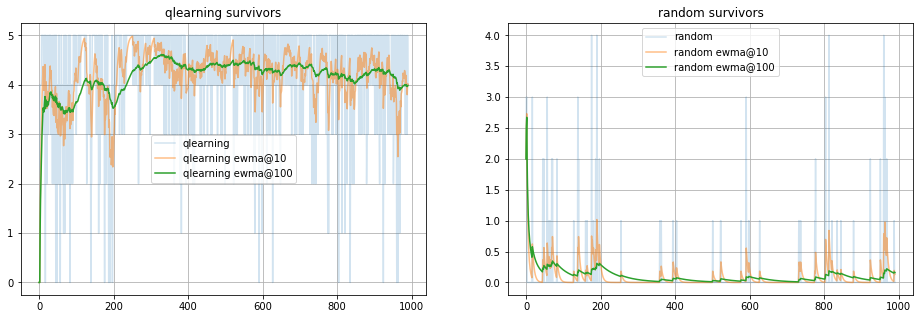

In [4]:
n_epochs = 1000
max_ticks = 1000
stats = []

for epoch in range(n_epochs):
    env.reset()
    for i in range(max_ticks):
        done = env.step()

        if done:
            break
    
    stats.append(env.members)
    
    if epoch % 10 == 0:
        clear_output(True)
        
        qlearning, random = zip(*stats)
        plt.figure(figsize=(16, 5))
        plt.subplot(1, 2, 1)
        plot_stats(qlearning, name='qlearning')

        plt.subplot(1, 2, 2)
        plot_stats(random, name='random')
        plt.show()

In [5]:
from azkaban.monitor import VideoMonitor

def record_session(env, filename):
    wenv = VideoMonitor(env)
    wenv.reset(outfile=filename)

    done = False
    for i in range(1000):
        done = wenv.step()

        if done:
            break

    if not done:
        wenv.finish()

### Record session with Random agents
Exploration should be turned off before recording

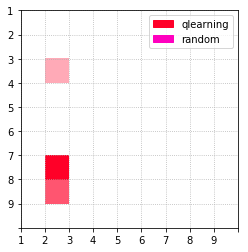

In [8]:
for item in env.agents:
    if isinstance(item['actor'], TeamsTabularQLearningAgent):
        item['actor'].epsilon = 0

record_session(env, 'qlearning_vs_random.mp4');

### Praise winners

In [9]:
from IPython.display import HTML

HTML("""
<video width="640" height="480" controls>
  <source src="{video}" type="video/mp4">
</video>
""".format(video='qlearning_vs_random.mp4'))